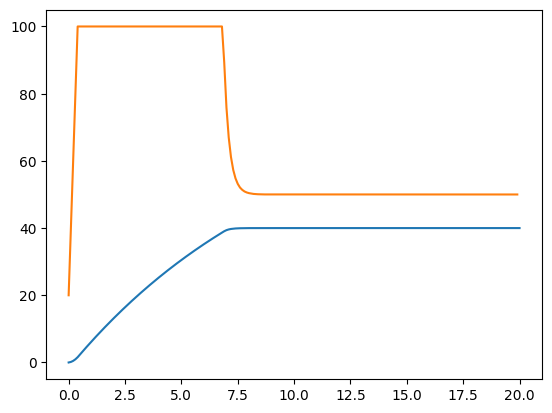

In [1]:
''' Author: Dimitris Pitsaris '''
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import solve_ivp


# Initial condition 
v_0 = 0.0

# Simulation parameters
m = 500  # Mass (kg)
b = 50   # Resistive coefficient (N-s/m)
K = 0.8  # Gain (m/s-%pedal)

# Time parameters
T_START = 0
T_END = 20
TIME_RANGE = int(T_END - T_START) # Absolute time 

# MPC parameters
dt = 0.1                         # Time step
L = int(TIME_RANGE / dt)         # Simulation steps
N_p = 7                         # Prediction horizon
Q = 10                            # Weight for tracking
R = 0.01                          # Weight for control effort
Q_term = 0.0                     # Weight for terminal state
OPTIMIZATION_METHOD = 'SLSQP'    # Optimization method. Other options: 'SLSQP, 'L-BFGS-B', 'trust-constr', 'COBYLA', 'Powell', 'Nelder-Mead'

p_MIN = 0.0
p_MAX = 100
BOUNDS = [(p_MIN, p_MAX) for _ in range(N_p)]  # Bounds for pedal position
p_dmax=20

#V_set
v_sp=40

def car_dynamics(t,v,p):
    dv_dt=(-v*b+K*b*p)/m
    return dv_dt

def discretized_model(t, v, p, h=dt):
    k1 = car_dynamics(t, v, p)
    k2 = car_dynamics(t + h / 2, v + k1 * h / 2, p)
    k3 = car_dynamics(t + h / 2, v + k2 * h / 2, p)
    k4 = car_dynamics(t + h, v + k3 * h, p)

    v_next = v + (h / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
    return v_next

# ----- Cost function -----
def cost_function(p_opt, v, p_last):
    J = 0
    v_curr = v
    for k in range(N_p):
        v_next = discretized_model(t, v_curr, p_opt[k])
        J += Q * (v_sp - v_next) ** 2
        if k > 0:
            J += R * (p_opt[k] - p_opt[k - 1]) ** 2
        v_curr = v_next
    return J

v = np.zeros(L+1)
p = np.zeros(L)
p_guess=np.zeros(N_p)
p_actual=[0]
v[0] = v_0


# MPC Loop
for step in range(L):
    t=step*dt
    # Constraints
    constraints = []
    constraints = [{'type':'ineq',
                    'fun': lambda p_opt, p_last=p[step-1] if step>0 else 0: p_dmax - abs(p_opt[0]-p_last)}]
    
    res = minimize(cost_function, p_guess,
                   args=(v[step], p[step - 1] if step > 0 else 0),
                   bounds=BOUNDS,
                   constraints=constraints, 
                   method=OPTIMIZATION_METHOD, tol=1e-6)
    if res.success:
        p[step] = res.x[0]
        p_actual.append(p[step])
        p_guess = res.x
    else:
        print(f"Warning: Optimization failed at step {step}, using previous p value")
        p[step] = p[step - 1] if step > 0 else 0  # Use fallback strategy
        p_guess = np.roll(p_guess, -1)  # Shift the previous optimal F values
        
    sol = solve_ivp(car_dynamics, t_span=[t, t + dt], y0=[v[step],], args=(p[step],), method='RK45')
    v[step + 1] = sol.y[0,-1]
    

plt.plot(np.arange(0, TIME_RANGE+dt, dt), v, label='Car Velocity')
plt.plot(np.arange(0, TIME_RANGE, dt), p, label='Gas pedal')
# plt.plot(np.arange(0,TIME_RANGE+dt,dt),p_actual)

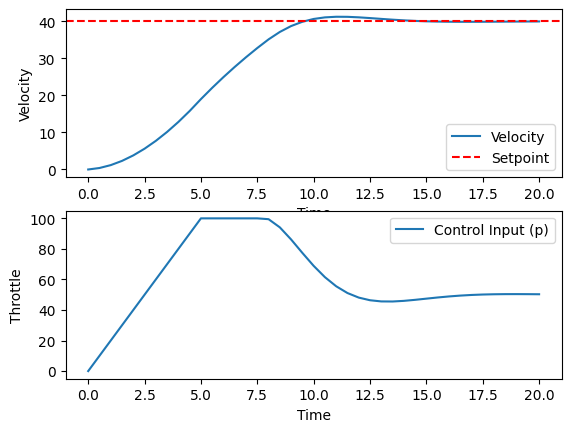

In [2]:
''' Author: Comex '''
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Time settings
time = np.linspace(0, 20, 41)
dt = time[1] - time[0]

# Constants
mass = 500
b = 50
K = 0.8

# Setpoint
v_sp = 40

# Initial conditions
v = np.zeros_like(time)
p = np.zeros_like(time)  # Ensure initial throttle is 0

# Cost function for MPC
def objective(p_seq, v_curr):
    v_pred = v_curr
    cost = 0
    p_prev = p[i]  # Previous control input
    for p_i in p_seq:
        dv = (-v_pred * b + K * b * p_i) / mass * dt
        v_pred += dv
        cost += (v_pred - v_sp) ** 2  # L2 norm tracking error
        cost += 0.1 * (p_i - p_prev) ** 2  # Penalize large changes in p
        p_prev = p_i
    return cost

# Constraints
bounds = [(0, 100) for _ in range(5)]  # Limit p within [0, 100]

# MPC loop
horizon = 5  # Predictive horizon
for i in range(len(time) - 1):
    res = minimize(objective, np.ones(horizon) * p[i], args=(v[i],), bounds=bounds, method='COBYLA')
    p_new = res.x[0]  # Suggested new control input
    p[i + 1] = np.clip(p[i] + np.clip(p_new - p[i], -10, 10), 0, 100)  # Enforce Δp ≤ 20
    v[i + 1] = v[i] + (-v[i] * b + K * b * p[i + 1]) / mass * dt

# Plot results
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(time, v, label="Velocity")
plt.axhline(y=v_sp, color='r', linestyle='--', label="Setpoint")
plt.xlabel("Time")
plt.ylabel("Velocity")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(time, p, label="Control Input (p)")
plt.xlabel("Time")
plt.ylabel("Throttle")
plt.legend()

plt.show()


In [3]:
import pandas as pd
df = pd.DataFrame({'time': time, 'velocity': v, 'throttle': p})

In [ ]:
#%%Import packages
import numpy as np
from random import random
from gekko import GEKKO
import matplotlib.pyplot as plt

#%% Build model

#initialize GEKKO model
m = GEKKO()

#time
m.time = np.linspace(0,20,41)

#constants
mass = 500

#Parameters
b = m.Param(value=50)
K = m.Param(value=0.8)
#Manipulated variable
p = m.MV(value=0, lb=0, ub=100)

#Controlled Variable
v = m.CV(value=0)

#Equations
m.Equation(mass*v.dt() == -v*b + K*b*p)

#%% Tuning

#global
m.options.IMODE = 6 #control

#MV tuning
p.STATUS = 1 #allow optimizer to change
p.DCOST = 0.1 #smooth out gas pedal movement
p.DMAX = 10 #slow down change of gas pedal

#CV tuning
#setpoint
v.STATUS = 1 #add the SP to the objective
m.options.CV_TYPE = 2 #L2 norm
v.SP = 40 #set point
v.TR_INIT = 1 #setpoint trajectory
v.TAU = 5 #time constant of setpoint trajectory

#%% Solve

m.solve()

#%% Plot solution
plt.figure()
plt.subplot(2,1,1)
plt.plot(m.time,p.value,'b-',linewidth=2)
plt.ylabel('gas')
plt.subplot(2,1,2)
plt.plot(m.time,v.value,'r--',linewidth=2)
plt.ylabel('velocity')
plt.xlabel('time')
plt.show()

In [ ]:
df['velocity_mpc'] = v.value    
df['throttle_mpc'] = p.value
df['vel_diff'] = df['velocity'] - df['velocity_mpc']
df['throttle_diff'] = df['throttle'] - df['throttle_mpc']
df['throttle_diff'].mean()

In [ ]:
df